# Simulated_Echo_SVC-2020-NL
## Claude de Rijke-Thomas
### 21st May 2021

In [1]:
import scipy.io
import numpy as np
from scipy.integrate import simps, trapz
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from numba import jit, prange
from scipy import signal
from scipy.interpolate import interp1d

# The Non-Lead Part (Including Non-Lead SVC)

NLP1 corresponds to:
$$h\_s = [0, 0.05, 0.10, 0.15] $$
$$l\_surf = [0:1:10]; % large-scale correlation length (default = 5 m) $$
$$sigma\_si = [0.001:0.0005:0.004]; % sea ice rms height (default = 0.002 m) $$
$$sigma\_surf = [0:0.05:0.5]; % large-scale rms roughness height (default = 0.1 m)$$
NLP2 corresponds to:
$$h\_s =  [0.20, 0.25, 0.30, 0.35]$$
$$l\_surf = [0:1:10]; % large-scale correlation length (default = 5 m) $$
$$sigma\_si = [0.001:0.0005:0.004]; % sea ice rms height (default = 0.002 m) $$
$$sigma\_surf = [0:0.05:0.5]; % large-scale rms roughness height (default = 0.1 m)$$
NLP3 corresponds to:
$$h\_s =  [0.40, 0.45, 0.50]$$
$$l\_surf = [0:1:10]; % large-scale correlation length (default = 5 m) $$
$$sigma\_si = [0.001:0.0005:0.004]; % sea ice rms height (default = 0.002 m) $$
$$sigma\_surf = [0:0.05:0.5]; % large-scale rms roughness height (default = 0.1 m)$$

In [2]:
waveform = np.loadtxt('/Users/claudederijkethomas/Desktop/Ice/Proj/CS_OFFL_SIR_SAR_1B_20140515T080546_20140515T081235_B001.wfm')


#Had to split the non-lead echo simulations into three parts for running on remote cluster: NLP1, NLP2 and NLP3
#(each took about 24 hours for non-lead, and 27 for lead on Myriad):
NLP1 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_NLP1.mat')
NLP2 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_NLP2.mat')
NLP3 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_NLP3.mat')

#added arrays containing values of the parameters iterated over (to be used as SVC labels):
sim_params = NLP1['parameters_lookup']
sim_params_2 = NLP2['parameters_lookup']
sim_params_3 = NLP3['parameters_lookup']

#simulated waveforms:
sim_echoes = NLP1['P_t_ml_range']
sim_echoes_2 = NLP2['P_t_ml_range']
sim_echoes_3 = NLP3['P_t_ml_range']

#extracting the fasttimes corresponding to the range bins:
fasttimes_1 = NLP1['t']
fasttimes_2 = NLP2['t']
fasttimes_3 = NLP3['t']


In [3]:
interpolation_factor = 100
gaussian = [(1/(5*np.sqrt(2*np.pi)))*np.exp(-((x - 35)**2)/(2*5**2)) for x in range(100)]
gauss_xnew = np.linspace(0, len(gaussian)-1, num=(len(gaussian)*interpolation_factor-(interpolation_factor-1)), endpoint=True)
gauss_interpolator = interp1d((range(len(gaussian))), gaussian, kind='linear')
gauss_interpolation = gauss_interpolator(gauss_xnew)
gauss_interp_peak_index = np.argmax(gauss_interpolation) #the peak index of the interpolated gaussian
gauss_interp_left_base = scipy.signal.peak_prominences(gauss_interpolation, [gauss_interp_peak_index], wlen=300*interpolation_factor)[1][0] #index of the left hand side base of the peak
print("gauss_interp_left_base",gauss_interp_left_base)
print(len(gauss_interpolation))
#halfway up the leading edge of the gaussian:
gauss_interp_leading_edge_halfway_up_index = np.argmin(abs(gauss_interpolation[:np.argmax(gauss_interpolation)] - np.max(gauss_interpolation)/2))
print("leading edge halfway up index: ",gauss_interp_leading_edge_halfway_up_index)
halfway_up_uninterp_index = int(gauss_interp_leading_edge_halfway_up_index/interpolation_factor)

gauss_interp_left_base 0
9901
leading edge halfway up index:  2911


sim_gauss_interp_leading_edge_halfway_up_shift 1586
sim_interp_leading_edge_halfway_up_index :  1325
len(sim_interpolation) 6901
gauss_interp_leading_edge_halfway_up_index 2911


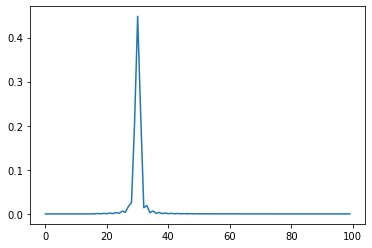

In [4]:
def extractNL():
    """extracting (and preprocessing) the simulated echo arrays into a format that can be understood by the SVC."""
    data_arr = []
    label_arr = []
    feature_arr = []
    
    graph_plot_counter=0
    for i in range(len(sim_echoes[:][:][:][:])): #snow depth{s} (h_s)
        for j in range(len(sim_echoes[0][:][:][:])): #l_surf{s}
            for k in range(len(sim_echoes[0][0][:][:])): #sigma_si{s}
                for l in range(len(sim_echoes[0][0][0][:])): #sigma_surf{s}
                    
                    """ Get rid of the %2 if time_sampling_factor = 1"""
                    #selecting one of the simulated echoes
                    simulated_echo = [sim_echoes[i][j][k][l][m][0] for m in range(len(sim_echoes[i][j][k][l])) if m%2==0 ]
                    #selecting the parameter values of the simulated echo:
                    sim_echo_params = [sim_params[i][j][k][l][0][n] for n in range(len(sim_params[i][j][k][l][0]))]
                    #calculating the area under the echo (for subsequent normalisation)
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    #normalising the echo
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor-(interpolation_factor-1)), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='linear')
                    sim_interpolation = sim_interpolator(sim_xnew)
                    
                    sim_interp_peak_index = np.argmax(sim_interpolation)
                    sim_interp_left_base = scipy.signal.peak_prominences(sim_interpolation, [sim_interp_peak_index])[1][0] #index of the left hand side base of the peak
                    
                    """new stuff added – trying to align to the halway up point of the leading edges instead of the centroid of the leading edge"""
                    step_index = sim_interp_left_base
                    #climbing up the leading edge of the echo to get the index of the halfway point (j):
                    while sim_interpolation[step_index]<(sim_interpolation[sim_interp_left_base]+sim_interpolation[sim_interp_peak_index])/2:
                        step_index = step_index + 1
                    sim_interp_leading_edge_halfway_up_index = step_index
                    
                    sim_gauss_interp_leading_edge_halfway_up_shift = -(sim_interp_leading_edge_halfway_up_index-gauss_interp_leading_edge_halfway_up_index)
                    
                    arr_sim_interp = []
                    #lining up the simulated echo's halfway up point with the abstract gaussian's halway up the leading edge point: 
                    for a in range(len(gauss_interpolation)):
                        try:
                            #So that I dont accidentally start plotting the -10th, -9th index etc:
                            if a-int(sim_gauss_interp_leading_edge_halfway_up_shift)>=0:
                                arr_sim_interp.append(sim_interpolation[a-int(sim_gauss_interp_leading_edge_halfway_up_shift)])
                            else:
                                arr_sim_interp.append(0)
                        except:
                            arr_sim_interp.append(0)
                    #uninterpolating the simulated echo:
                    sim_uninterp = [arr_sim_interp[b] for b in range(len(arr_sim_interp)) if b%interpolation_factor==0]
                    """ ending new stuff"""
                    
                    if graph_plot_counter<1:
                        print("sim_gauss_interp_leading_edge_halfway_up_shift",sim_gauss_interp_leading_edge_halfway_up_shift)
                        print("sim_interp_leading_edge_halfway_up_index : ", sim_interp_leading_edge_halfway_up_index)
                        print("len(sim_interpolation)", len(sim_interpolation))
                        print("gauss_interp_leading_edge_halfway_up_index",gauss_interp_leading_edge_halfway_up_index)
                        
                        plt.plot(sim_uninterp)
                        plt.show()
                        graph_plot_counter+=1
                    #appending the leading edge to the feature_arr, as well as the whole echo after it (so that the leading edge has more of an effect on the classification):
                    feature_arr.append(np.append(sim_uninterp[halfway_up_uninterp_index-10:halfway_up_uninterp_index+10],sim_uninterp))
                    #appending echo parameters to a label array (for the classification)
                    label_arr.append(str(sim_echo_params))
                    
    for i in range(len(sim_echoes_2[:][:][:][:])): #snow depth{s} (h_s)
        for j in range(len(sim_echoes_2[0][:][:][:])): #l_surf{s}
            for k in range(len(sim_echoes_2[0][0][:][:])): #sigma_si{s}
                for l in range(len(sim_echoes_2[0][0][0][:])): #sigma_surf{s}
                    
                    """ Get rid of the %2 if time_sampling_factor = 1"""
                    simulated_echo = [sim_echoes_2[i][j][k][l][m][0] for m in range(len(sim_echoes_2[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params_2[i][j][k][l][0][n] for n in range(len(sim_params_2[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor-(interpolation_factor-1)), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='linear')
                    sim_interpolation = sim_interpolator(sim_xnew)
                    sim_interp_peak_index = np.argmax(sim_interpolation)
                    sim_interp_left_base = scipy.signal.peak_prominences(sim_interpolation, [sim_interp_peak_index])[1][0] #index of the left hand side base of the peak
                    
                    """new stuff added – trying to align to the halway up point of the leading edges instead of the centroid of the leading edge"""
                    step_index = sim_interp_left_base
                    #climbing up the leading edge of the echo to get the index of the halfway point (j):
                    while sim_interpolation[step_index]<(sim_interpolation[sim_interp_left_base]+sim_interpolation[sim_interp_peak_index])/2:
                        step_index = step_index + 1
                    sim_interp_leading_edge_halfway_up_index = step_index
                    
                    sim_gauss_interp_leading_edge_halfway_up_shift = -(sim_interp_leading_edge_halfway_up_index-gauss_interp_leading_edge_halfway_up_index)
                    
                    arr_sim_interp = []
                    #lining up the simulated echo's halfway up point with the abstract gaussian's halway up the leading edge point: 
                    for a in range(len(gauss_interpolation)):
                        try:
                            #So that I dont accidentally start plotting the -10th, -9th index etc:
                            if a-int(sim_gauss_interp_leading_edge_halfway_up_shift)>=0:
                                arr_sim_interp.append(sim_interpolation[a-int(sim_gauss_interp_leading_edge_halfway_up_shift)])
                            else:
                                arr_sim_interp.append(0)
                        except:
                            arr_sim_interp.append(0)
                    sim_uninterp = [arr_sim_interp[b] for b in range(len(arr_sim_interp)) if b%interpolation_factor==0]
                    """ ending new stuff"""
                    #appending the leading edge to the feature_arr, as well as the whole echo after it (so that the leading edge has more of an effect on the classification):
                    feature_arr.append(np.append(sim_uninterp[halfway_up_uninterp_index-10:halfway_up_uninterp_index+10],sim_uninterp))
                    #appending echo parameters to a label array (for the classification)
                    label_arr.append(str(sim_echo_params))
                    
    
    for i in range(len(sim_echoes_3[:][:][:][:])): #snow depth{s} (h_s)
        for j in range(len(sim_echoes_3[0][:][:][:])): #l_surf{s}
            for k in range(len(sim_echoes_3[0][0][:][:])): #sigma_si{s}
                for l in range(len(sim_echoes_3[0][0][0][:])): #sigma_surf{s}
                    
                    """ Get rid of the %2 if time_sampling_factor = 1"""
                    simulated_echo = [sim_echoes_3[i][j][k][l][m][0] for m in range(len(sim_echoes_3[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params_3[i][j][k][l][0][n] for n in range(len(sim_params_3[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor-(interpolation_factor-1)), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='linear')
                    sim_interpolation = sim_interpolator(sim_xnew)
                    sim_interp_peak_index = np.argmax(sim_interpolation)
                    sim_interp_left_base = scipy.signal.peak_prominences(sim_interpolation, [sim_interp_peak_index])[1][0] #index of the left hand side base of the peak
            
                    """new stuff added – trying to align to the halway up point of the leading edges instead of the centroid of the leading edge"""
                    step_index = sim_interp_left_base
                    #climbing up the leading edge of the echo to get the index of the halfway point (j):
                    while sim_interpolation[step_index]<(sim_interpolation[sim_interp_left_base]+sim_interpolation[sim_interp_peak_index])/2:
                        step_index = step_index + 1
                    sim_interp_leading_edge_halfway_up_index = step_index
                    
                    sim_gauss_interp_leading_edge_halfway_up_shift = -(sim_interp_leading_edge_halfway_up_index-gauss_interp_leading_edge_halfway_up_index)
                    
                    arr_sim_interp = []
                    #lining up the simulated echo's halfway up point with the abstract gaussian's halway up the leading edge point: 
                    for a in range(len(gauss_interpolation)):
                        try:
                            #So that I dont accidentally start plotting the -10th, -9th index etc:
                            if a-int(sim_gauss_interp_leading_edge_halfway_up_shift)>=0:
                                arr_sim_interp.append(sim_interpolation[a-int(sim_gauss_interp_leading_edge_halfway_up_shift)])
                            else:
                                arr_sim_interp.append(0)
                        except:
                            arr_sim_interp.append(0)
                    sim_uninterp = [arr_sim_interp[b] for b in range(len(arr_sim_interp)) if b%interpolation_factor==0]
                    """ ending new stuff"""
                    
                    #appending the leading edge to the feature_arr, as well as the whole echo after it (so that the leading edge has more of an effect on the classification):
                    feature_arr.append(np.append(sim_uninterp[halfway_up_uninterp_index-10:halfway_up_uninterp_index+10],sim_uninterp))
                    #appending echo parameters to a label array (for the classification)
                    label_arr.append(str(sim_echo_params))
                    
    return np.array(feature_arr),np.array(label_arr) 
feature_arr,label_arr = extractNL() #for features for both the SVC and neural network, labels for the SVC and for labels for the neural network



In [5]:
#making the parameter labels strings so that the SVC can interpret them
label_arr = np.array(label_arr, dtype = 'str')
clfL = SVC(gamma='auto') #creating the lead suppport vector classification
clfL.fit(feature_arr, label_arr) #training the lead SVC using the simulated echoes and their corresponding parameters

SVC(gamma='auto')

# Evaluating Parameters of a CryoSat-2 Waveform

In [6]:
waveform_number = 3000 #pick between 0 and 8539

#initialising arrays for the different parts of the CryoSat-2 waveform file
source_packet_ID = []
block_no = []
not_used = []
lat = [] #latitude
lon = [] #longitude
waveform_data = []

#extracting different parts of Cryosat-2 waveform file
for row in waveform:
    source_packet_ID.append(row[0])
    block_no.append(row[1])
    not_used.append(row[2])
    lat.append(row[3])
    lon.append(row[4])
    waveform_data.append(row[5:-1])


print("There are",len(waveform_data[waveform_number]), "points in this waveform.")
#calculating area under waveform:
waveform_data_area = simps(waveform_data[waveform_number], dx=1)
#normalising waveform data:
norm_waveform_data = [x/waveform_data_area for x in waveform_data[waveform_number]]
obs_xnew = np.linspace(0, len(norm_waveform_data)-1, num=(len(norm_waveform_data)*interpolation_factor-(interpolation_factor-1)), endpoint=True)
obs_interpolator = interp1d((range(len(norm_waveform_data))), norm_waveform_data, kind='linear')
#zero padding the end of the interpolated observed echo so that scipy understands that 
#the base of the echo peak is the initial noise floor:
obs_interpolation = np.append(obs_interpolator(obs_xnew),np.zeros(1000))
print("len(obs_interpolation)", len(obs_interpolation))
obs_interp_peak_index = np.argmax(obs_interpolation)
print("obs_interp_peak_index", obs_interp_peak_index)
obs_interp_left_base = scipy.signal.peak_prominences(obs_interpolation, [obs_interp_peak_index], wlen=300*interpolation_factor)[1][0] #index of the left hand side base of the peak
print("obs_interp_left_base",obs_interp_left_base)
# print("obs_interp_left_base",obs_interp_left_base)

step_index = obs_interp_left_base
#climbing up the leading edge of the echo to get the index of the halfway point (j):
while obs_interpolation[step_index]<(obs_interpolation[obs_interp_left_base]+obs_interpolation[obs_interp_peak_index])/2:
    step_index = step_index + 1
obs_interp_leading_edge_halfway_up_index = step_index

obs_gauss_interp_leading_edge_halfway_up_shift = -(obs_interp_leading_edge_halfway_up_index-gauss_interp_leading_edge_halfway_up_index)
arr_obs_interp = []
#lining up the observed echo's halfway up point with the abstract gaussian's halway up the leading edge point: 
for a in range(len(gauss_interpolation)):
    try:
        #So that I dont accidentally start plotting the -10th, -9th index etc:
        if a-int(obs_gauss_interp_leading_edge_halfway_up_shift)>=0:
            arr_obs_interp.append(obs_interpolation[a-int(obs_gauss_interp_leading_edge_halfway_up_shift)])
        else:
            arr_obs_interp.append(0)
    except:
        arr_obs_interp.append(0)
obs_uninterp = [arr_obs_interp[b] for b in range(len(arr_obs_interp)) if b%interpolation_factor==0]




There are 127 points in this waveform.
len(obs_interpolation) 13601
obs_interp_peak_index 5000
obs_interp_left_base 300


In [7]:
#predicting the parameters of the Cryosat-2 echo (snow_depth, l_surf, sigma_si, sigma_surf)
prediction = np.asarray(clfL.predict([np.append(obs_uninterp[halfway_up_uninterp_index-10:halfway_up_uninterp_index+10],obs_uninterp)])[0])
print("SNOW PREDICTION: ",prediction)

SNOW PREDICTION:  [0.5, 10.0, 0.001, 0.05]


Echo number3:  9241
peak indices:  [1500]
1500
0.0002981056820542394
Snow-ice interface threshold_fraction:  0.8282673035999708


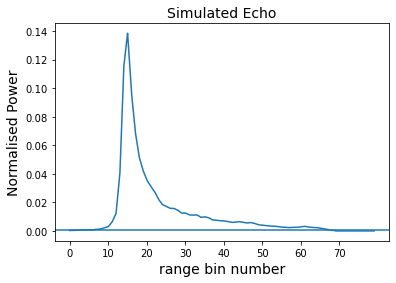

In [8]:
"""Figuring out which one of the simulated echoes the Cryosat-2 echo matched"""
counter = 0
for i in range(len(sim_echoes[:][:][:][:])): #snow depth{s} (h_s)
    for j in range(len(sim_echoes[0][:][:][:])): #l_surf{s}
        for k in range(len(sim_echoes[0][0][:][:])): #sigma_si{s}
            for l in range(len(sim_echoes[0][0][0][:])): #sigma_surf{s}
                sim_echo_params = [sim_params[i][j][k][l][0][n] for n in range(len(sim_params[i][j][k][l][0]))]
                if str(sim_echo_params) == prediction:
                    print("Echo number: ",counter)
                    simulated_echo_number = counter
                    simulated_echo = [sim_echoes[i][j][k][l][m][0] for m in range(len(sim_echoes[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params[i][j][k][l][0][n] for n in range(len(sim_params[i][j][k][l][0]))]
                    simulated_echo_area = simps(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor-(interpolation_factor-1)), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='linear')
                    #zero padding the end of the interpolated simulated echo so that scipy understands that 
                    #the base of the echo peak is the initial noise floor:
                    sim_interpolation = np.append(sim_interpolator(sim_xnew), np.zeros(1000))
                    plt.title("Simulated Echo", fontsize = 14)
                    plt.ylabel("Normalised Power", fontsize = 14)
                    plt.xticks([0,1000,2000,3000,4000,5000,6000,7000], [0,10,20,30,40,50,60,70])
                    plt.xlabel("range bin number", fontsize =14)
                    plt.plot(sim_interpolation)
                    print(np.shape(sim_interpolation[0]))
                    #mean snow-ice interface range bin index accounting for oversampling factor and interpolation factor:
                    mean_snow_ice_interface_surface_index = list(fasttimes_1[0]).index(0)/2*interpolation_factor

                    major_peak_index = np.argmax(sim_interpolation) #finding the index of the largest peak in the echo
#                     print("sim_interp_peak_index",major_peak_index)
                    peak_indices = signal.find_peaks(sim_interpolation, width = 150, height = 0.04)[0] #finding all the indices of all the peaks in the echo
                    print("peak indices: ",peak_indices)
                    print(np.argmax(sim_interpolation))
                    #finding the peak-to-trough depth of the largest (major) peak in the echo:
                    max_peak_depth = signal.peak_prominences(sim_interpolation,peak_indices)[0][list(peak_indices).index(major_peak_index)]
                    peak_threshold = sim_interpolation[int(mean_snow_ice_interface_surface_index)]

                    mean_snow_ice_interface_threshold_fraction = 1 - (np.max(sim_interpolation) - peak_threshold)/max_peak_depth

                    print("Snow-ice interface threshold_fraction: ",mean_snow_ice_interface_threshold_fraction)
                    plt.axhline(y=np.max(sim_interpolation)-max_peak_depth)
                counter+=1



for i in range(len(sim_echoes_2[:][:][:][:])): #snow depth{s} (h_s)
    for j in range(len(sim_echoes_2[0][:][:][:])): #l_surf{s}
        for k in range(len(sim_echoes_2[0][0][:][:])): #sigma_si{s}
            for l in range(len(sim_echoes_2[0][0][0][:])): #sigma_surf{s}
                sim_echo_params = [sim_params_2[i][j][k][l][0][n] for n in range(len(sim_params_2[i][j][k][l][0]))]
                #print(i,j,k,sim_echo_params,prediction)
                if str(sim_echo_params) == prediction:
                    print("Echo number2: ",counter)
                    simulated_echo_number = counter
                    simulated_echo = [sim_echoes_2[i][j][k][l][m][0] for m in range(len(sim_echoes_2[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params_2[i][j][k][l][0][n] for n in range(len(sim_params_2[i][j][k][l][0]))]
                    simulated_echo_area = simps(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor-(interpolation_factor-1)), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='linear')
                    #zero padding the end of the interpolated simulated echo so that scipy understands that 
                    #the base of the echo peak is the initial noise floor:
                    sim_interpolation = np.append(sim_interpolator(sim_xnew), np.zeros(1000))
                    plt.title("Simulated Echo", fontsize = 14)
                    plt.ylabel("Normalised Power", fontsize = 14)
                    plt.xticks([0,1000,2000,3000,4000,5000,6000,7000], [0,10,20,30,40,50,60,70])
                    plt.xlabel("range bin number", fontsize =14)
                    plt.plot(sim_interpolation)
                    #mean snow-ice interface range bin index accounting for oversampling factor and interpolation factor:
                    mean_snow_ice_interface_surface_index = list(fasttimes_2[0]).index(0)/2*interpolation_factor

                    major_peak_index = np.argmax(sim_interpolation) #finding the index of the largest peak in the echo
#                     print("sim_interp_peak_index",major_peak_index)
                    peak_indices = signal.find_peaks(sim_interpolation, width = 150, height = 0.04)[0] #finding all the indices of all the peaks in the echo
                    print("peak indices: ",peak_indices)
                    print(np.argmax(sim_interpolation))
                    #finding the peak-to-trough depth of the largest (major) peak in the echo:
                    max_peak_depth = signal.peak_prominences(sim_interpolation,peak_indices)[0][list(peak_indices).index(major_peak_index)]
                    print(np.max(sim_interpolation)-max_peak_depth)
                    plt.axhline(y=np.max(sim_interpolation)-max_peak_depth)
                    peak_threshold = sim_interpolation[int(mean_snow_ice_interface_surface_index)]
                    print(np.max(sim_interpolation)-max_peak_depth)
                    mean_snow_ice_interface_threshold_fraction = 1 - (np.max(sim_interpolation) - peak_threshold)/max_peak_depth
                    print("Snow-ice interface threshold_fraction: ",mean_snow_ice_interface_threshold_fraction)
                    plt.axhline(y=np.max(sim_interpolation)-max_peak_depth)
                counter+=1
        
for i in range(len(sim_echoes_3[:][:][:][:])): #snow depth{s} (h_s)
    for j in range(len(sim_echoes_3[0][:][:][:])): #l_surf{s}
        for k in range(len(sim_echoes_3[0][0][:][:])): #sigma_si{s}
            for l in range(len(sim_echoes_3[0][0][0][:])): #sigma_surf{s}
                sim_echo_params = [sim_params_3[i][j][k][l][0][n] for n in range(len(sim_params_3[i][j][k][l][0]))]
                #print(i,j,k,sim_echo_params,prediction)
                if str(sim_echo_params) == prediction:
                    print("Echo number3: ",counter)
                    simulated_echo_number = counter
                    simulated_echo = [sim_echoes_3[i][j][k][l][m][0] for m in range(len(sim_echoes_3[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params_3[i][j][k][l][0][n] for n in range(len(sim_params_3[i][j][k][l][0]))]
                    simulated_echo_area = simps(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor-(interpolation_factor-1)), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='linear')
                    #zero padding the end of the interpolated simulated echo so that scipy understands that 
                    #the base of the echo peak is the initial noise floor:
                    sim_interpolation = np.append(sim_interpolator(sim_xnew), np.zeros(1000))
                    plt.title("Simulated Echo", fontsize = 14)
                    plt.ylabel("Normalised Power", fontsize = 14)
                    plt.xticks([0,1000,2000,3000,4000,5000,6000,7000], [0,10,20,30,40,50,60,70])
                    plt.xlabel("range bin number", fontsize =14)
                    plt.plot(sim_interpolation)
                    #mean snow-ice interface range bin index accounting for oversampling factor and interpolation factor:
                    mean_snow_ice_interface_surface_index = list(fasttimes_3[0]).index(0)/2*interpolation_factor

                    major_peak_index = np.argmax(sim_interpolation) #finding the index of the largest peak in the echo

                    peak_indices = signal.find_peaks(sim_interpolation, width = 150, height = 0.04)[0] #finding all the indices of all the peaks in the echo
                    print("peak indices: ",peak_indices)
                    print(np.argmax(sim_interpolation))
                    #finding the peak-to-trough depth of the largest (major) peak in the echo:
                    max_peak_depth = signal.peak_prominences(sim_interpolation,peak_indices)[0][list(peak_indices).index(major_peak_index)]
                    print(np.max(sim_interpolation)-max_peak_depth)
                    peak_threshold = sim_interpolation[int(mean_snow_ice_interface_surface_index)]
                    plt.axhline(y=np.max(sim_interpolation)-max_peak_depth)
                    mean_snow_ice_interface_threshold_fraction = 1 - (np.max(sim_interpolation) - peak_threshold)/max_peak_depth
                    print("Snow-ice interface threshold_fraction: ",mean_snow_ice_interface_threshold_fraction)

                counter+=1

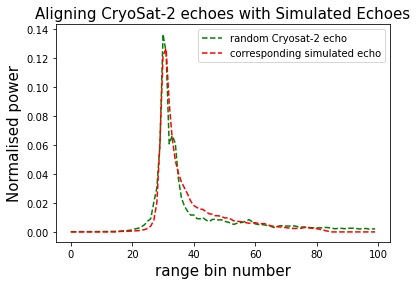

In [9]:
"""Plotting the Cryosat-2 echo and corresponding simulated echo"""
plt.title('Aligning CryoSat-2 echoes with Simulated Echoes', fontsize = 15)
plt.plot(range(len(obs_uninterp)), obs_uninterp, 'g--', label='random Cryosat-2 echo')
plt.plot(range(len(feature_arr[simulated_echo_number][20:])), feature_arr[simulated_echo_number][20:], 'r--',label = 'corresponding simulated echo')
# plt.plot(range(len(gaussian)), gaussian, label = 'abstract gaussian both are aligned to')
plt.xlabel('range bin number', fontsize = 15)
plt.ylabel('Normalised power', fontsize = 15)
plt.legend(loc = 'upper right')
plt.savefig('RandomCryoSat2EchoNL.png', dpi= 200)

In [10]:
print("Threshold_fraction: ",mean_snow_ice_interface_threshold_fraction)

Threshold_fraction:  0.8282673035999708


In [11]:
major_peak_index = np.argmax(obs_interpolation) #finding the index of the largest peak in the echo

peak_indices = signal.find_peaks(obs_interpolation, width = 150, height = 0.04)[0] #finding all the indices of all the peaks in the echo

#finding the peak-to-trough depth of the largest (major) peak in the echo:
max_peak_depth = signal.peak_prominences(obs_interpolation,peak_indices)[0][list(peak_indices).index(major_peak_index)]
#the y value of on the observed echo, corresponding to the adjusted TFMRA threshold fraction 
threshold_value = np.max(obs_interpolation)-max_peak_depth + mean_snow_ice_interface_threshold_fraction*max_peak_depth
#calculating the retracking range bin of the observed echo corresponding to the TFMRA estimated from the closest corresponding
#simulated echo:
retracking_range_bin_for_obs_waveform = np.argmin(abs(obs_interpolation[:major_peak_index]-threshold_value))/interpolation_factor
print(retracking_range_bin_for_obs_waveform)

49.71


retracking_range_bin_for_obs_waveform:  49.71


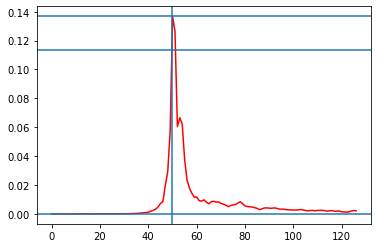

In [21]:
print("retracking_range_bin_for_obs_waveform: ",retracking_range_bin_for_obs_waveform)
plt.plot(norm_waveform_data, 'r')
plt.axvline(x=retracking_range_bin_for_obs_waveform)
plt.axhline(y=threshold_value)
plt.axhline(y=np.max(norm_waveform_data))
plt.axhline(y=np.max(norm_waveform_data)-max_peak_depth)
plt.show()